様々な言語の Spell と Sound (IPA) の構造を LDA で探索する
黒田　航　(kow.kuroda@gmail.com)

2024/03/26 i. FastText のエンコードを追加; ii. UMAP を使った次元圧縮を追加; iii. DBSCANクラスターに帰属する個数の相関をHeatmap にする処理を追加

2024/06/30 i. ngrams_skippy.py, ngrams.py の参照を gen_ngrams.py に更新．それにより，skippy4gram の追加; ii. unicode character decomposition を無効化．これにより，アクセント記号を整合的に扱えるようになった

In [1]:
## imports
import sys, os, random, re, glob
import pandas as pd
import pprint as pp
#from functools import reduce

設定

In [2]:
## 処理設定
verbose = False

## 全言語をカバーできる色パレットの用意
import plotly
color_palette = plotly.colors.qualitative.Dark24

In [3]:
### LDA 用 (FastText と併用可能)
use_LDA = True

## トピック数
n_topics      = 15 # 30は多過ぎる？

### DTM 構築: doc, term の設定
## doc
doc_type      = 'form'  # 変更不可
doc_attrs     = [ 'spell', 'sound' ]
doc_attr      = doc_attrs[1]
print(f"doc_attr: {doc_attr}")

## doc の長さの上限
max_doc_size  = 15
print(f"max_doc_size: {max_doc_size}")

## doc の長さの下限
min_doc_size  = 3
print(f"min_doc_size: {min_doc_size}")

## ngram を包括的にするかどうか
ngram_is_inclusive = True

## term
term_size         = 'character' # 出力用の名目変数
#term_types        = re.split(r",\s+", "1gram, 2gram, 3gram, skippy2gram, skippy3gram")
term_types        = [ '1gram', '2gram', '3gram', '4gram',
                     'skippy2gram', 'skippy3gram', 'skippy4gram' ]
lda_term_type     = term_types[-3]
print(f"lda_term_type: {lda_term_type}")

## term の最低頻度
term_min_freq = 1

## 高頻度 term の濫用指標: 大きくし過ぎないように．terms の異なりが小さいので0.03 は十分に大きい
term_abuse_threshold = 0.01

## skippy n-gram の表記
gap_mark = "…"

## skippy n-gram の結合範囲
max_gap_size = round(max_doc_size * 0.8)
print(f"max_gap_size for skippy n-grams: {max_gap_size}")

doc_attr: sound
max_doc_size: 15
min_doc_size: 3
lda_term_type: skippy2gram
max_gap_size for skippy n-grams: 12


In [4]:
## FastText を使うか (LDA と併用可能)
use_FastText = True

## term
ft_term_types = [ '1gram', '2gram', '3gram', '4gram', 'skippy2grm', 'skippy3gram', 'skippy4gram' ]
ft_term_type = ft_term_types[3]
print(f"ft_term_type: {ft_term_type}")

## window size
ft_window_size = 5
print(f"ft_window_size: {ft_window_size}")

## dimension = vector size
ft_n_dims_factor = 2
ft_n_dims = round(n_topics * ft_n_dims_factor)
print(f"ft_n_dims: {ft_n_dims}")

ft_term_type: 4gram
ft_window_size: 5
ft_n_dims: 30


In [5]:
## 設定の確認
assert use_LDA or use_FastText

if use_LDA:
    if use_FastText:
        encoding_method = "LDA x FastText"
    else:
        encoding_method = "LDA"
else:
    encoding_method = "FastText"

In [6]:
## tSNE 用

## 実行前にサンプリングするかどうか
doc_fit_sampling      = True
doc_fit_sampling_rate = 0.2

## perplexity を決めるパラメター
top_perplexity_reduct_rate = 0.5
#doc_perplexity_reduct_rate = 0.3 # 段階的に変化させる

In [7]:
## UMAP の設定

## correlation の他のmetric は良くない
umap_metrics     = [ 'correlation',
                    'cosine', 'euclidean', 'braycurtis', 'canberra', 'manhattan', 'minkowski'
                    'mahalanobis' ]
umap_metric      = umap_metrics[0]

## n_neighbors
umap_n_neighbors = 6

## min_dist
umap_min_dist    = 0.3

In [8]:
## DBSCAN clustering 用

DBSCAN_uses_UMAP = True # False ならtSNE を使う


# 言語の選別

In [9]:
## 言語の選別
select_languages = True

## 言語の割合の均等化
balanced = True

## 色分けで言語名の変わりに語族を使う
color_lang_family = False

## 英語をゲルマン語に含める
germanic_includes_english = False

## スラブ語属を設定する
use_slavic = False # russian, czech を一緒にするのは条件付き

## ルーマニア語をロマンス語に含める
romance_includes_romanian = False

## ルーマニア語をスラブ語に含める
slavic_includes_romanian = False

In [10]:
##音声解析で使える言語
## arabic, chinese, english, esperanto, french, german, icelandic, japanese, korean, spanish, swahili

##綴り解析で使える言語
## arabic, bengali, chinese, czech, esperanto, english, finnish, french,
## galician, german, greek, hebrew, hungarian, icelandic, irish, italian,
## japanese, romanian, russian, spanish, swahili, turkish, welsh

import re
## sound sets
sound_set0 = "arabic, chinese, dutch, english, esperato, french, german, icelandic, \
    japanese, korean, spanish, swahili"
sound_set1 = "arabic, dutch, english, esperanto, french, german, icelandic, \
    japanese, korean, spanish, swahili"
#
sound_set_romance = "esperanto, french, galician, spanish"
sound_set_germanic = "english, german, icelandic"
sound_set_semitic = "arabic, hebrew"
sound_set_asian = "chinese, japanese, korean"

## spell sets
spell_set0 = "arabic, bengali, chinese, czech, dutch, esperato, english, finnish, french, \
    galician, german, greek, hebrew, hungarian, icelandic, irish, italian, japanese, korean, \
        romanian, russian, spanish, swahili, turkish, welsh"
spell_set1 = "arabic, czech, hebrew, dutch, english, esperanto, finnish, french, german, greek, \
    hungarian, icelandic, irish, romanian, russian, italian, spanish, swahili, turkish, welsh"
spell_set2 = "dutch, english, esperanto, french, finnish, german, hungarian, icelandic, irish, italian, \
    spanish, swahili, turkish, welsh"
spell_set3 = "dutch, english, esperanto, finnish, german, hungarian, irish, swahili, turkish, welsh"
#
spell_set_celtic     = "irish, welsh"
spell_set_celtic_x   = "irish, welsh, icelandic"
spell_set_germanic   = "dutch, german, icelandic"
spell_set_germanic_x = "dutch, english, german, icelandic"
spell_set_romance    = "esperanto, french, italian, spanish"
spell_set_romance_x  = "esperanto, french, italian, spanish, romanian"
spell_set_slavic     = "czech, russian"

## selection
selected_langs = re.split(r",\s*", sound_set1)
print(f"selected {len(selected_langs)} languages:\n{selected_langs}")

selected 11 languages:
['arabic', 'dutch', 'english', 'esperanto', 'french', 'german', 'icelandic', 'japanese', 'korean', 'spanish', 'swahili']


In [11]:
## load data to process
from pathlib import Path
import pprint as pp
wd = Path(".")
dirs = [ x for x in wd.iterdir() if x.is_dir() and not x.match(r"plot*") ]
if verbose:
    print(f"The following {len(dirs)} directories are potential targets:")
    pp.pprint(dirs)

## list up files in target directory 
target_dir = "data-words" # can be changed
target_files = sorted(list(wd.glob(f"{target_dir}/*.csv")))
print(f"\n{target_dir} contains {len(target_files)} files to process")
if verbose:
    pp.pprint(target_files)


data-words contains 36 files to process


In [12]:
import pandas as pd
## データ型の辞書
types = re.split(r",\s+", "spell, sound")
type_settings = { t : 0 for t in types }
print(type_settings)

## 言語名の辞書
lang_settings = { lang : 0 for lang in selected_langs }
print(f"{len(lang_settings.keys())} langs are targeted")
print(lang_settings)

## 辞書と統合
settings = { **type_settings, **lang_settings }
print(settings)

{'spell': 0, 'sound': 0}
11 langs are targeted
{'arabic': 0, 'dutch': 0, 'english': 0, 'esperanto': 0, 'french': 0, 'german': 0, 'icelandic': 0, 'japanese': 0, 'korean': 0, 'spanish': 0, 'swahili': 0}
{'spell': 0, 'sound': 0, 'arabic': 0, 'dutch': 0, 'english': 0, 'esperanto': 0, 'french': 0, 'german': 0, 'icelandic': 0, 'japanese': 0, 'korean': 0, 'spanish': 0, 'swahili': 0}


In [13]:
## function to undo Unicode character decomposition
import unicodedata
def undecompose(W: list):
    # Crucially! str(..)
    return [ unicodedata.normalize('NFC', str(x)) for x in W ]

In [14]:
## Obtain data from files
check = False
setting_keys = list(settings.keys())
print(f"target setting_keys: {setting_keys}")
d_parts = [ ]
for lang in lang_settings.keys():
    local_settings = settings.copy()
    if check:
        print(f"processing: {lang}")
    try:
        ## ファイル単位で処理
        for f in [ f for f in target_files if lang.capitalize() in str(f) ]:
            print(f"reading: {f}")
            
            # 言語名の指定
            local_settings[lang] = 1
            
            # 型名の指定
            for key in type_settings.keys():
                if key in str(f):
                    local_settings[key] = 1
                else:
                    local_settings[key] = 0 # この変更を見落とさないように
            
            # ファイル処理
            try:
                data = pd.read_csv(f, encoding = 'utf-8', sep = ",", on_bad_lines = 'skip') # Crucially, ...= skip
                if check:
                    print(data)
                #dfx = pd.DataFrame(data, columns = setting_keys)
                dfx = pd.DataFrame(data, columns = ['form', 'freq'])
                ## undo Unicode character decompostion
                dfx['form'] = undecompose(dfx['form'])
                ##
                for key in settings.keys():
                    dfx[key] = local_settings[key]
                    if check:
                        print(dfx)
                d_parts.append(dfx)
            except FileNotFoundError:
                pass
    except IndexError:
        pass
#
if verbose:
    d_parts

target setting_keys: ['spell', 'sound', 'arabic', 'dutch', 'english', 'esperanto', 'french', 'german', 'icelandic', 'japanese', 'korean', 'spanish', 'swahili']
reading: data-words/base-sound-Arabic-r0-1k-mc.csv
reading: data-words/base-spell-Arabic-r0-1k-mc.csv
reading: data-words/base-sound-Dutch-r0-1k-mc.csv
reading: data-words/base-spell-Dutch-r0-1k-mc.csv
reading: data-words/base-sound-English-r6e-original.csv


reading: data-words/base-spell-English-r6e-original.csv
reading: data-words/base-sound-Esperanto-r0-1k-mc-sorted.csv
reading: data-words/base-spell-Esperanto-r0-orginal.csv
reading: data-words/base-sound-French-r0-1k-mc.csv
reading: data-words/base-sound-French-r0-opendic-s900.csv
reading: data-words/base-spell-French-r0-1k-mc.csv
reading: data-words/base-sound-German-r1a-original.csv
reading: data-words/base-spell-German-r1a-original.csv
reading: data-words/base-sound-Icelandic-r0-1k-mc.csv
reading: data-words/base-spell-Icelandic-r0-original.csv
reading: data-words/base-sound-Japanese-r0-1k-mc.csv
reading: data-words/base-spell-Japanese-r0-1k-mc.csv
reading: data-words/base-sound-Korean-r0-1k-mc-sorted.csv
reading: data-words/base-sound-Spanish-r0-1k-mc.csv
reading: data-words/base-spell-Spanish-r0-1k-mc.csv
reading: data-words/base-sound-Swahili-r0-1k-mc.csv
reading: data-words/base-spell-Swahili-r0-1k-mc.csv


In [15]:
## データ統合
raw_df = pd.concat(d_parts)
raw_df

,form,freq,spell,sound,arabic,dutch,english,esperanto,french,german,icelandic,japanese,korean,spanish,swahili
0,kamaː,1.0,0,1,1,0,0,0,0,0,0,0,0,0,0
1,ʔanaː,1.0,0,1,1,0,0,0,0,0,0,0,0,0,0
2,lahu,1.0,0,1,1,0,0,0,0,0,0,0,0,0,0
3,ʔan,1.0,0,1,1,0,0,0,0,0,0,0,0,0,0
4,huːa,1.0,0,1,1,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
703,zaidi,1.0,1,0,0,0,0,0,0,0,0,0,0,0,1
704,ziara,1.0,1,0,0,0,0,0,0,0,0,0,0,0,1
705,zima,1.0,1,0,0,0,0,0,0,0,0,0,0,0,1
706,ziwa,1.0,1,0,0,0,0,0,0,0,0,0,0,0,1


In [16]:
## form の小文字化
raw_df[doc_type] = raw_df[doc_type].apply(lambda x: x.lower())

In [17]:
## 言語名= language の列を追加
check = False
language_vals = [ ]
for i, row in raw_df.iterrows():
    if check:
        print(row)
    for j, lang in enumerate(selected_langs):
        if check:
            print(f"{i}: {lang}")
        if row[lang] == 1:
            language_vals.append(lang)
if verbose:
    print(language_vals)
    len(language_vals)
#
raw_df['language'] = language_vals
raw_df

,form,freq,spell,sound,arabic,dutch,english,esperanto,french,german,icelandic,japanese,korean,spanish,swahili,language
0,kamaː,1.0,0,1,1,0,0,0,0,0,0,0,0,0,0,arabic
1,ʔanaː,1.0,0,1,1,0,0,0,0,0,0,0,0,0,0,arabic
2,lahu,1.0,0,1,1,0,0,0,0,0,0,0,0,0,0,arabic
3,ʔan,1.0,0,1,1,0,0,0,0,0,0,0,0,0,0,arabic
4,huːa,1.0,0,1,1,0,0,0,0,0,0,0,0,0,0,arabic
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
703,zaidi,1.0,1,0,0,0,0,0,0,0,0,0,0,0,1,swahili
704,ziara,1.0,1,0,0,0,0,0,0,0,0,0,0,0,1,swahili
705,zima,1.0,1,0,0,0,0,0,0,0,0,0,0,0,1,swahili
706,ziwa,1.0,1,0,0,0,0,0,0,0,0,0,0,0,1,swahili


In [18]:
## 言語族 family 列の追加
# germanic
if germanic_includes_english:
    germanic_langs = [ 'english', 'dutch', 'german', 'icelandic' ]
else:
    germanic_langs = [ 'dutch', 'german', 'icelandic' ]
# celtic
celtic_langs       = [ 'irish', 'welsh' ]
# romance
if romance_includes_romanian:
    romance_langs  = [ 'esperanto', 'galician', 'french', 'romanian', 'italian', 'spanish' ]
else:
    romance_langs  = [ 'esperanto', 'galician', 'french', 'italian', 'spanish' ]
# slavic
if use_slavic:
    if slavic_includes_romanian:
        slavic_langs   = [ 'czech', 'romanian', 'russian' ]
    else:
        slavic_langs   = [ 'czech', 'russian' ]
else:
    slavic_langs = [ ]
#
check = False
family_vals = [ ]
for i, row in raw_df.iterrows():
    if check:
        print(row)
    lang = row['language']
    if check:
        print(f"{i}: {lang}")
    # romance langs
    if lang in celtic_langs:
        family_vals.append('celtic')
    # romance langs
    elif lang in romance_langs:
        family_vals.append('romance')
    # germanic langs
    elif lang in germanic_langs:
        family_vals.append('germanic')
    # slavic langs
    elif lang in slavic_langs:
        family_vals.append('slavic')
    # all others
    else:
        family_vals.append(lang)
#
if verbose:
    print(family_vals)
    len(family_vals)
#
raw_df['family'] = family_vals
raw_df

,form,freq,spell,sound,arabic,dutch,english,esperanto,french,german,icelandic,japanese,korean,spanish,swahili,language,family
0,kamaː,1.0,0,1,1,0,0,0,0,0,0,0,0,0,0,arabic,arabic
1,ʔanaː,1.0,0,1,1,0,0,0,0,0,0,0,0,0,0,arabic,arabic
2,lahu,1.0,0,1,1,0,0,0,0,0,0,0,0,0,0,arabic,arabic
3,ʔan,1.0,0,1,1,0,0,0,0,0,0,0,0,0,0,arabic,arabic
4,huːa,1.0,0,1,1,0,0,0,0,0,0,0,0,0,0,arabic,arabic
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
703,zaidi,1.0,1,0,0,0,0,0,0,0,0,0,0,0,1,swahili,swahili
704,ziara,1.0,1,0,0,0,0,0,0,0,0,0,0,0,1,swahili,swahili
705,zima,1.0,1,0,0,0,0,0,0,0,0,0,0,0,1,swahili,swahili
706,ziwa,1.0,1,0,0,0,0,0,0,0,0,0,0,0,1,swahili,swahili


In [19]:
## 文字数の列を追加
raw_df['size'] = [ len(x) for x in raw_df[doc_type] ]
raw_df

,form,freq,spell,sound,arabic,dutch,english,esperanto,french,german,icelandic,japanese,korean,spanish,swahili,language,family,size
0,kamaː,1.0,0,1,1,0,0,0,0,0,0,0,0,0,0,arabic,arabic,5
1,ʔanaː,1.0,0,1,1,0,0,0,0,0,0,0,0,0,0,arabic,arabic,5
2,lahu,1.0,0,1,1,0,0,0,0,0,0,0,0,0,0,arabic,arabic,4
3,ʔan,1.0,0,1,1,0,0,0,0,0,0,0,0,0,0,arabic,arabic,3
4,huːa,1.0,0,1,1,0,0,0,0,0,0,0,0,0,0,arabic,arabic,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
703,zaidi,1.0,1,0,0,0,0,0,0,0,0,0,0,0,1,swahili,swahili,5
704,ziara,1.0,1,0,0,0,0,0,0,0,0,0,0,0,1,swahili,swahili,5
705,zima,1.0,1,0,0,0,0,0,0,0,0,0,0,0,1,swahili,swahili,4
706,ziwa,1.0,1,0,0,0,0,0,0,0,0,0,0,0,1,swahili,swahili,4


In [20]:
## 解析データの型指定
print(f"doc_attr: {doc_attr}")
raw_df = raw_df[raw_df[doc_attr] == 1]
raw_df

doc_attr: sound


,form,freq,spell,sound,arabic,dutch,english,esperanto,french,german,icelandic,japanese,korean,spanish,swahili,language,family,size
0,kamaː,1.0,0,1,1,0,0,0,0,0,0,0,0,0,0,arabic,arabic,5
1,ʔanaː,1.0,0,1,1,0,0,0,0,0,0,0,0,0,0,arabic,arabic,5
2,lahu,1.0,0,1,1,0,0,0,0,0,0,0,0,0,0,arabic,arabic,4
3,ʔan,1.0,0,1,1,0,0,0,0,0,0,0,0,0,0,arabic,arabic,3
4,huːa,1.0,0,1,1,0,0,0,0,0,0,0,0,0,0,arabic,arabic,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
878,pua,1.0,0,1,0,0,0,0,0,0,0,0,0,0,1,swahili,swahili,3
879,wiᵑgi,1.0,0,1,0,0,0,0,0,0,0,0,0,0,1,swahili,swahili,5
880,hasiɾa,1.0,0,1,0,0,0,0,0,0,0,0,0,0,1,swahili,swahili,6
881,maɗai,1.0,0,1,0,0,0,0,0,0,0,0,0,0,1,swahili,swahili,5


In [21]:
## 言語の選別
if select_languages:
    df_new = [ ]
    for lang in selected_langs:
        df_new.append(raw_df[raw_df[lang] == 1])
    raw_df = pd.concat(df_new)
#
raw_df

,form,freq,spell,sound,arabic,dutch,english,esperanto,french,german,icelandic,japanese,korean,spanish,swahili,language,family,size
0,kamaː,1.0,0,1,1,0,0,0,0,0,0,0,0,0,0,arabic,arabic,5
1,ʔanaː,1.0,0,1,1,0,0,0,0,0,0,0,0,0,0,arabic,arabic,5
2,lahu,1.0,0,1,1,0,0,0,0,0,0,0,0,0,0,arabic,arabic,4
3,ʔan,1.0,0,1,1,0,0,0,0,0,0,0,0,0,0,arabic,arabic,3
4,huːa,1.0,0,1,1,0,0,0,0,0,0,0,0,0,0,arabic,arabic,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
878,pua,1.0,0,1,0,0,0,0,0,0,0,0,0,0,1,swahili,swahili,3
879,wiᵑgi,1.0,0,1,0,0,0,0,0,0,0,0,0,0,1,swahili,swahili,5
880,hasiɾa,1.0,0,1,0,0,0,0,0,0,0,0,0,0,1,swahili,swahili,6
881,maɗai,1.0,0,1,0,0,0,0,0,0,0,0,0,0,1,swahili,swahili,5


/var/folders/yh/c68mhtcj6yn7qsl201kw_7zw0000gn/T/ipykernel_14516/1748787432.py:11: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


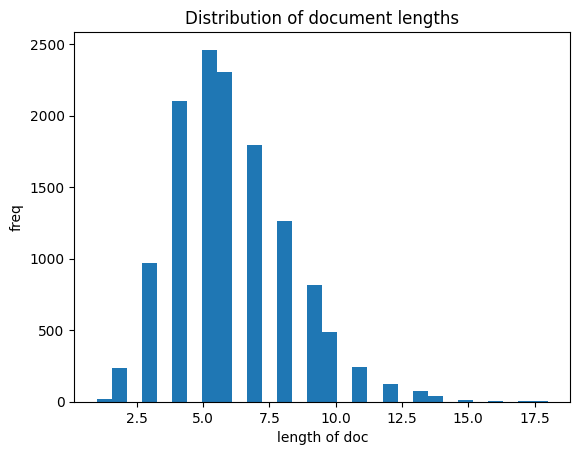

In [22]:
## 文字数の分布
import numpy as np
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.hist(raw_df['size'], bins = 30)
ax.set_xlabel('length of doc')
ax.set_ylabel('freq')
plt.title(f"Distribution of document lengths")
fig.show()

データを長さで濾過

In [23]:
## 長過ぎる語の除外 
print(f"max doc size: {max_doc_size}")
original_size = len(raw_df)
raw_df = raw_df[raw_df['size'] <= max_doc_size]
max_filtered_size = len(raw_df)
print(f"{original_size - max_filtered_size} cases removed due to max_doc_size")

## 短過ぎる語の除外
print(f"min doc size: {min_doc_size}")
raw_df = raw_df[raw_df['size'] >= min_doc_size]
min_filtered_size = len(raw_df)
print(f"{max_filtered_size - min_filtered_size} cases removed due to min_doc_size")
#
print(f"{original_size - min_filtered_size} cases removed in total")

max doc size: 15
11 cases removed due to max_doc_size
min doc size: 3
253 cases removed due to min_doc_size
264 cases removed in total


In [24]:
## 結果の検査 1
for type in types:
    print(raw_df[type].value_counts(sort = True))

spell
0    12700
Name: count, dtype: int64
sound
1    12700
Name: count, dtype: int64


In [25]:
## 結果の検査 2
for lang in selected_langs:
    print(raw_df[lang].value_counts(sort = True).sort_index())

arabic
0    11977
1      723
Name: count, dtype: int64
dutch
0    11621
1     1079
Name: count, dtype: int64
english
0    8559
1    4141
Name: count, dtype: int64
esperanto
0    11972
1      728
Name: count, dtype: int64
french
0    11700
1     1000
Name: count, dtype: int64
german
0    11911
1      789
Name: count, dtype: int64
icelandic
0    11764
1      936
Name: count, dtype: int64
japanese
0    11916
1      784
Name: count, dtype: int64
korean
0    11979
1      721
Name: count, dtype: int64
spanish
0    11772
1      928
Name: count, dtype: int64
swahili
0    11829
1      871
Name: count, dtype: int64


英語事例の割合補正

In [26]:
## 統合: 割合補正を適用
eng_reduct_factor = 0.2
if balanced:
    try:
        eng_df = raw_df[raw_df['english'] == 1]
        non_eng_df = raw_df[raw_df['english'] == 0]
        eng_reduced_df = eng_df.sample(round(len(eng_df) * eng_reduct_factor))
        raw_df = pd.concat([eng_reduced_df, non_eng_df])
    except KeyError:
        pass
#
raw_df

,form,freq,spell,sound,arabic,dutch,english,esperanto,french,german,icelandic,japanese,korean,spanish,swahili,language,family,size
1054,hɛzəteɪt,1.0,0,1,0,0,1,0,0,0,0,0,0,0,0,english,english,8
203,blɔɪəɹ,1.0,0,1,0,0,1,0,0,0,0,0,0,0,0,english,english,6
2640,sɪstəm,1.0,0,1,0,0,1,0,0,0,0,0,0,0,0,english,english,6
2900,tʃɑk,1.0,0,1,0,0,1,0,0,0,0,0,0,0,0,english,english,4
3993,ɹɑbɪn,1.0,0,1,0,0,1,0,0,0,0,0,0,0,0,english,english,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
878,pua,1.0,0,1,0,0,0,0,0,0,0,0,0,0,1,swahili,swahili,3
879,wiᵑgi,1.0,0,1,0,0,0,0,0,0,0,0,0,0,1,swahili,swahili,5
880,hasiɾa,1.0,0,1,0,0,0,0,0,0,0,0,0,0,1,swahili,swahili,6
881,maɗai,1.0,0,1,0,0,0,0,0,0,0,0,0,0,1,swahili,swahili,5


In [27]:
## 結果の検査 3
for lang in selected_langs:
    print(raw_df[lang].value_counts().sort_index())

arabic
0    8664
1     723
Name: count, dtype: int64
dutch
0    8308
1    1079
Name: count, dtype: int64
english
0    8559
1     828
Name: count, dtype: int64
esperanto
0    8659
1     728
Name: count, dtype: int64
french
0    8387
1    1000
Name: count, dtype: int64
german
0    8598
1     789
Name: count, dtype: int64
icelandic
0    8451
1     936
Name: count, dtype: int64
japanese
0    8603
1     784
Name: count, dtype: int64
korean
0    8666
1     721
Name: count, dtype: int64
spanish
0    8459
1     928
Name: count, dtype: int64
swahili
0    8516
1     871
Name: count, dtype: int64


# 解析

In [28]:
## 順序のランダマイズし，基本データを決定
import sklearn.utils
main_df = sklearn.utils.shuffle(raw_df)

DTM 構築の準備

In [29]:
## module 探索範囲の拡張
import sys
sys.path.append('..')

import re
import ngrams
import importlib
importlib.reload(ngrams)
import ngrams_skippy

# name the shared variable
bases = main_df[doc_type]
bases

600           uːvər
2526         sutəbl
704           to̞um
11             nani
254          heiːra
           ...     
3510       ɪntəɹnɛt
144             ima
724     finɑ̃sasjɔ̃
335      ɯtsɯkɯɕisa
563            egao
Name: form, Length: 9387, dtype: object

In [30]:
## 1gram 列の追加
unigrams = bases.apply(lambda x: re.split(r"", x))
## remove null elements
unigrams = [ [ u for u in x if len(u) > 0 ] for x in unigrams ]
if verbose:
    random.sample(unigrams, 5)
#
main_df['1gram'] = unigrams
if verbose:
    main_df

In [31]:
## 2gram の作成
bigrams = ngrams.list_gen_bigrams(bases, sep = r"", check = False)
## make n-gram inclusive
if ngram_is_inclusive:
    bigrams = [ [*b, *u] for b, u in zip(bigrams, unigrams) ]
#
pp.pprint(random.sample(bigrams, 3))

## 2gram列の追加
main_df['2gram'] = bigrams
if verbose:
    main_df

[['t͡',
  '͡ɕ',
  'ɕi',
  'ik',
  'ks',
  's͈',
  '͈ʌ',
  'ʌ̹',
  '̹n',
  't',
  '͡',
  'ɕ',
  'i',
  'k',
  's',
  '͈',
  'ʌ',
  '̹',
  'n'],
 ['çɛ', 'ɛː', 'ːr', 'ç', 'ɛ', 'ː', 'r'],
 ['kɯ', 'ɯɾ', 'ɾa', 'as', 'sɯ', 'k', 'ɯ', 'ɾ', 'a', 's', 'ɯ']]


In [32]:
## 3gram の作成
trigrams = ngrams.list_gen3grams(bases, sep = r"", check = False)
## make n-grams inclusive
if ngram_is_inclusive:
    trigrams = [ [ *t, *b ] for t, b in zip(trigrams, bigrams) ]
pp.pprint(random.sample(trigrams, 2))
## 3gram列の追加
main_df['3gram'] = trigrams
if verbose:
    main_df

[['nʌ̹', 'ʌ̹m', '̹mu', 'nʌ', 'ʌ̹', '̹m', 'mu', 'n', 'ʌ', '̹', 'm', 'u'],
 ['ma̠', 'a̠ɭ', 'ma', 'a̠', '̠ɭ', 'm', 'a', '̠', 'ɭ']]


In [33]:
## 4gram の作成
import gen_ngrams
quadrigrams = [ gen_ngrams.gen_ngrams(x, n = 4, sep = "", check = False) for x in main_df['1gram'] ]
## make n-grams inclusive
if ngram_is_inclusive:
    trigrams = [ [ *t, *b ] for t, b in  zip(quadrigrams, trigrams) ]
pp.pprint(random.sample(quadrigrams, 2))
## 3gram列の追加
main_df['4gram'] = quadrigrams
if verbose:
    main_df

[['pund', 'und͡', 'nd͡ʑ', 'd͡ʑa', '͡ʑa̠'],
 ['t͡ɕa', '͡ɕa̠', 'ɕa̠ŋ', 'a̠ŋm', '̠ŋmi']]


In [34]:
## skippy 2grams の生成

#import ngrams_skippy
import gen_ngrams
#skippy_2grams = [ ngrams_skippy.gen_skippy_bigrams(x, missing_mark = gap_mark,
#                                                    max_distance = max_gap_size, check = False) for x in main_df['1gram'] ]
## the code above was replaced by the following efficient one
skippy2grams = [ gen_ngrams.gen_skippy_ngrams(x, n = 2, sep = "", max_distance = max_gap_size,
                                               missing_mark = gap_mark, check = False) for x in main_df['1gram'] ]

## 包括的 skippy 2-grams の生成
if ngram_is_inclusive:
    for i, b2 in enumerate(skippy2grams):
        b2.extend(unigrams[i])
#
pp.pprint(random.sample(skippy2grams, 2))

## skippy 2gram 列の追加
main_df['skippy2gram'] = skippy2grams
if verbose:
    main_df

[['sa',
  's…j',
  's…a',
  's…ɾ',
  's…i',
  'aj',
  'a…a',
  'a…ɾ',
  'a…i',
  'ja',
  'j…ɾ',
  'j…i',
  'aɾ',
  'a…i',
  'ɾi',
  'aj',
  'a…a',
  'a…ɾ',
  'a…i',
  'ja',
  'j…ɾ',
  'j…i',
  'aɾ',
  'a…i',
  'ɾi',
  'ja',
  'j…ɾ',
  'j…i',
  'aɾ',
  'a…i',
  'ɾi',
  'aɾ',
  'a…i',
  'ɾi',
  'ɾi',
  's',
  'a',
  'j',
  'a',
  'ɾ',
  'i'],
 ['ni',
  'n…n',
  'n…i',
  'in',
  'i…i',
  'ni',
  'in',
  'i…i',
  'ni',
  'ni',
  'n',
  'i',
  'n',
  'i']]


In [35]:
## skippy 3grams の生成
#import ngrams_skippy
#skippy_3grams = [ ngrams_skippy.gen_skippy3grams(x, missing_mark = gap_mark,
#                                                         max_distance = max_gap_size, check = False) for x in main_df['1gram'] ]
## the code above was replaced by the following efficient one
import gen_ngrams
skippy3grams = [ gen_ngrams.gen_skippy_ngrams(x, n = 3, sep = "",
                                               missing_mark = gap_mark,
                                                max_distance = max_gap_size, check = False)
                  for x in main_df['1gram'] ]

## 包括的 skippy 3-grams の生成
if ngram_is_inclusive:
    for i, t3 in enumerate(skippy3grams):
        t3.extend(skippy2grams[i])
#
pp.pprint(random.sample(skippy3grams, 2))

## skippy 3gram 列の追加
main_df['skippy3gram'] = skippy3grams
if verbose:
    main_df

[['keɴ',
  'ke…s',
  'ke…a',
  'ke…k',
  'ke…ɯ',
  'k…ɴs',
  'k…ɴ…a',
  'k…ɴ…k',
  'k…ɴ…ɯ',
  'k…sa',
  'k…s…k',
  'k…s…ɯ',
  'k…ak',
  'k…a…ɯ',
  'k…kɯ',
  'eɴs',
  'eɴ…a',
  'eɴ…k',
  'eɴ…ɯ',
  'e…sa',
  'e…s…k',
  'e…s…ɯ',
  'e…ak',
  'e…a…ɯ',
  'e…kɯ',
  'ɴsa',
  'ɴs…k',
  'ɴs…ɯ',
  'ɴ…ak',
  'ɴ…a…ɯ',
  'ɴ…kɯ',
  'sak',
  'sa…ɯ',
  's…kɯ',
  'akɯ',
  'eɴs',
  'eɴ…a',
  'eɴ…k',
  'eɴ…ɯ',
  'e…sa',
  'e…s…k',
  'e…s…ɯ',
  'e…ak',
  'e…a…ɯ',
  'e…kɯ',
  'ɴsa',
  'ɴs…k',
  'ɴs…ɯ',
  'ɴ…ak',
  'ɴ…a…ɯ',
  'ɴ…kɯ',
  'sak',
  'sa…ɯ',
  's…kɯ',
  'akɯ',
  'ɴsa',
  'ɴs…k',
  'ɴs…ɯ',
  'ɴ…ak',
  'ɴ…a…ɯ',
  'ɴ…kɯ',
  'sak',
  'sa…ɯ',
  's…kɯ',
  'akɯ',
  'sak',
  'sa…ɯ',
  's…kɯ',
  'akɯ',
  'akɯ',
  'ke',
  'k…ɴ',
  'k…s',
  'k…a',
  'k…k',
  'k…ɯ',
  'eɴ',
  'e…s',
  'e…a',
  'e…k',
  'e…ɯ',
  'ɴs',
  'ɴ…a',
  'ɴ…k',
  'ɴ…ɯ',
  'sa',
  's…k',
  's…ɯ',
  'ak',
  'a…ɯ',
  'kɯ',
  'eɴ',
  'e…s',
  'e…a',
  'e…k',
  'e…ɯ',
  'ɴs',
  'ɴ…a',
  'ɴ…k',
  'ɴ…ɯ',
  'sa',
  's…k',
  's…ɯ',
  'ak',
  'a

In [36]:
## skippy 4grams の生成
import gen_ngrams
skippy4grams = [ gen_ngrams.gen_skippy_ngrams(x, n = 4, sep = "",
                                               missing_mark = gap_mark,
                                                max_distance = max_gap_size, check = False)
                  for x in main_df['1gram'] ]

## 包括的 skippy 4-grams の生成
if ngram_is_inclusive:
    for i, t4 in enumerate(skippy4grams):
        t4.extend(skippy3grams[i])
#
pp.pprint(random.sample(skippy4grams, 2))

## skippy 3gram 列の追加
main_df['skippy4gram'] = skippy4grams
if verbose:
    main_df

[['zɪtə',
  'zɪt',
  'zɪ…ə',
  'z…tə',
  'ɪtə',
  'ɪtə',
  'zɪ',
  'z…t',
  'z…ə',
  'ɪt',
  'ɪ…ə',
  'tə',
  'ɪt',
  'ɪ…ə',
  'tə',
  'tə',
  'z',
  'ɪ',
  't',
  'ə'],
 ['haɔp',
  'haɔ…t',
  'ha…pt',
  'h…ɔpt',
  'aɔpt',
  'aɔpt',
  'haɔ',
  'ha…p',
  'ha…t',
  'h…ɔp',
  'h…ɔ…t',
  'h…pt',
  'aɔp',
  'aɔ…t',
  'a…pt',
  'ɔpt',
  'aɔp',
  'aɔ…t',
  'a…pt',
  'ɔpt',
  'ɔpt',
  'ha',
  'h…ɔ',
  'h…p',
  'h…t',
  'aɔ',
  'a…p',
  'a…t',
  'ɔp',
  'ɔ…t',
  'pt',
  'aɔ',
  'a…p',
  'a…t',
  'ɔp',
  'ɔ…t',
  'pt',
  'ɔp',
  'ɔ…t',
  'pt',
  'pt',
  'h',
  'a',
  'ɔ',
  'p',
  't']]


DTM 構築

In [37]:
## LDA 構築の基になる document-term matrix (dtm) を構築

from gensim.corpora.dictionary import Dictionary
bots = main_df[lda_term_type] # 後で参照するので変数化しておく
diction = Dictionary(bots)

## 結果の確認
print(diction)

Dictionary<5946 unique tokens: ['r', 'u', 'uː', 'u…r', 'u…v']...>


In [38]:
## diction の濾過
import copy
diction_copy = copy.deepcopy(diction)

## filter適用: 実は諸刃の刃で，token数が少ない時には適用しない方が良い
print(f"min freq filter: {term_min_freq}")
print(f"abuse filter: {term_abuse_threshold}")

apply_filter = True
if apply_filter:
    diction_copy.filter_extremes(no_below = term_min_freq, no_above = term_abuse_threshold)

## check
print(diction_copy)

min freq filter: 1
abuse filter: 0.01
Dictionary<5458 unique tokens: ['u…r', 'u…v', 'u…ə', 'və', 'ər']...>


In [39]:
## Corpus (gensim の用語では corpus) の構築
corpus = [ diction.doc2bow(bot) for bot in bots ]
check = False
if check:
    sample_n = 5
    print(random.sample(corpus, sample_n))
#
print(f"Number of documents: {len(corpus)}")

Number of documents: 9387


LDA モデルの構築

In [40]:
## LDA モデルの構築
from gensim.models import LdaModel as LDAmodel
print(f"Building LDA model with n_topics: {n_topics}")
doc_lda = LDAmodel(corpus, id2word = diction, num_topics = n_topics, alpha = 0.01)
print(doc_lda) # print(..)しないと中身が見れない

Building LDA model with n_topics: 15
LdaModel<num_terms=5946, num_topics=15, decay=0.5, chunksize=2000>


In [41]:
%%capture --no-display

## LDA のtopic ごとに，関連度の高い term を表示
import pandas as pd
n_terms = 30 # topic ごとに表示する term 数の指定
topic_dfs = [ ]
for topic in range(n_topics):
    terms = [ ]
    for i, prob in doc_lda.get_topic_terms(topic, topn = n_terms):
        terms.append(diction.id2token[ int(i) ])
    #
    topic_dfs.append(pd.DataFrame([terms], index = [ f'topic {topic+1}' ]))
#
topic_term_df = pd.concat(topic_dfs)

## Table で表示
topic_term_df.T

,topic 1,topic 2,topic 3,topic 4,topic 5,topic 6,topic 7,topic 8,topic 9,topic 10,topic 11,topic 12,topic 13,topic 14,topic 15
0,əɹ,ɔ̃,a…a,ːð,ːr,a…a,e…o,ː…ə,a…a,a…a,əʁ,a…i,a,ɪ,o
1,ɛ̝,a…j,aː,ð,ː,a,e,ə,a,ma,ʁɛ,i…a,ɾi,eɪ,o…o
2,ɛl,jɔ,a,a,uː,d…a,en,eː,a̠,a,ɑ̃,a,a…a,ɪ…ɪ,ʌ̹
3,ɛ,j…̃,ˤa,ða,r,ab,o,ə…ə,u…a,m,ə…ɛ,i,aɾ,t,i…o
4,s,je,l…a,að,iː,o̞,e…a,də,i…a,nt,ʁ,i…i,ɾɯ,ɪ…t,a…o
5,st,i…j,ː…a,ɪ,ːt,ba,a…o,əl,k…a,m…a,a…ʁ,a…a,a…ɯ,za,to
6,t,ʁ…̃,a…ː,l,ʏr,a…b,n…o,i…ə,a…i,n,ʁ…ʁ,ta,ta,ɪt,o…i
7,ɹ,sj,k̚,rð,a…r,d͡,e…t,ɪ…ə,ka,al,ɯ…ɯ,as,i,e,k…o
8,a,s…ɔ,a…d,ð…r,t,dʒ,t…o,ː,k,m…n,ʁa,s,oː,le,ko
9,ːr,a…ɔ,a…ˤ,lɪ,ː…r,l…a,nt,e…ə,k…i,ɛ…t,ɛ,si,a…ɾ,n,k


LDAvis の実行

In [42]:
%%capture --no-display

## pyLDAvis を使った結果 LDA の可視化: 階層クラスタリングより詳しい
import pyLDAvis
installed_version = pyLDAvis.__version__
print(f"installed_version: {installed_version}")

if float(installed_version[:3]) > 3.1:
    import pyLDAvis.gensim_models as gensimvis
else:
    import pyLDAvis.gensim as gensimvis
#
pyLDAvis.enable_notebook()
#
lda_used     = doc_lda
corpus_used  = corpus
diction_used = diction

## 実行パラメター: MMDS かtSNEを選ぶと "JSON object is too complex" error を回避できる 
LDAvis_use_MMDS  = False
LDAvis_use_tSNE  = False
if LDAvis_use_MMDS:
    vis = gensimvis.prepare(lda_used, corpus_used, diction_used, mds = 'mmds',
                            n_jobs = 1, sort_topics = False)
elif LDAvis_use_tSNE:
    vis = gensimvis.prepare(lda_used, corpus_used, diction_used, mds = 'tsne',
                            n_jobs = 1, sort_topics = False)
else:
    vis = gensimvis.prepare(lda_used, corpus_used, diction_used,
                            n_jobs = 1, sort_topics = False)
#
pyLDAvis.display(vis)
## topic を表わす円の重なりが多いならn_topics が多過ぎる可能性がある．
## ただし2Dで重なっていても，3Dなら重なっていない可能性もある

In [43]:
## LDA がD に対して生成した topics の弁別性を確認
## 得られたtopics を確認
topic_dist = doc_lda.get_topics()
if verbose:
    topic_dist

In [44]:
## 検査 1: topic ごとに分布の和を取る
print(topic_dist.sum(axis = 1))

[1.         1.         1.         1.         1.0000001  1.
 1.         1.         0.99999994 1.0000001  1.         1.
 0.9999999  1.         1.        ]


In [45]:
## 検査 2: 総和を求める: n_topics にほぼ等しいなら正常
print(topic_dist.sum())

15.000001


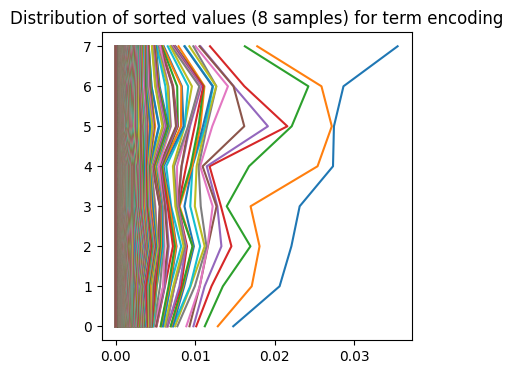

In [46]:
## term エンコード値の分布を確認
import matplotlib.pyplot as plt

plt.figure(figsize = (4,4))
df_size = len(topic_dist)
sampling_rate = 0.5
sample_n = round(df_size * sampling_rate)
topic_sampled = random.sample(list(topic_dist), sample_n)

T = sorted([ sorted(x, reverse = True) for x in topic_sampled ])
plt.plot(T, range(len(T)))
plt.title(f"Distribution of sorted values ({sample_n} samples) for term encoding")
plt.show()

In [47]:
## tSNE を使った topics のグループ化 (3D)
from sklearn.manifold import TSNE as tSNE
import numpy as np

## tSNE のパラメターを設定
## n_components は射影先の空間の次元: n_components = 3 なら3次元空間に射影
ppl_val = round(len(topic_dist) * top_perplexity_reduct_rate)
top_tSNE_3d = tSNE(n_components = 3, random_state = 0, perplexity = ppl_val, n_iter = 1000)

## データに適用
top_tSNE_3d_fitted = top_tSNE_3d.fit_transform(np.array(topic_dist))

In [48]:
## Plotlyを使って tSNE の結果の可視化 (3D)
import plotly.graph_objects as go
top_fitted = top_tSNE_3d_fitted
fig = go.Figure(data = [go.Scatter3d(
        x = top_fitted[:,0], y = top_fitted[:,1], z = top_fitted[:,2],
                                     mode = 'markers')
                                     ])

## 3D 散布図にラベルを追加する処理は未実装
title_val = f"t-SNE 3D map of LDA topics (#topics: {n_topics}; doc: {doc_attr}; term: {lda_term_type})"
fig.update_layout(autosize = False, width = 600, height = 600, title = title_val)
fig.show()

# doc 分類

In [49]:
if check:
    main_df

In [50]:
## LDA モデルを使って doc をエンコード

print(f"get LDA encodings for documents")
check    = False
lda_encoding = [ ]
for i, row in main_df.iterrows():
    if check:
        print(f"row: {row}")
    doc = row[doc_type]
    bot = row[lda_term_type]
    ## get_document_topics(..) では　minimu_probability = 0 としないと
    ## 値が十分に大きな topics に関してだけ値が取れる
    enc = doc_lda.get_document_topics(diction.doc2bow(bot), minimum_probability = 0)
    if check:
        print(f"enc: {enc}")
    lda_encoding.append([ e[-1] for e in enc ])
#
pp.pprint(random.sample(lda_encoding, 2))
print(f"#documents processed: {len(lda_encoding)}")

get LDA encodings for documents
[[0.0007068355,
  0.0007068355,
  0.31276807,
  0.0007068355,
  0.0007068355,
  0.0007068355,
  0.0007068355,
  0.0007068355,
  0.0007068355,
  0.0007068355,
  0.0007068355,
  0.45624232,
  0.0007068355,
  0.0007068355,
  0.22250758],
 [0.0007069053,
  0.6729436,
  0.0007069053,
  0.0007069053,
  0.0007069053,
  0.0007069053,
  0.0007069053,
  0.0007069053,
  0.0007069053,
  0.31786668,
  0.0007069053,
  0.0007069053,
  0.0007069053,
  0.0007069053,
  0.0007069053]]
#documents processed: 9387


In [51]:
## FastText を使ったエンコードの準備

from gensim.models import FastText

## build a model: for better comparison, vector_size should be equal to n_topics
print(f"get FastText encodings for documents")
## emulate sentences by concatenating character 1-grams by whitespaces
ft_corpus = [ " ".join(x) for x in main_df[ft_term_type] ]
random.sample(ft_corpus, 3)


get FastText encodings for documents


['θanɪ anɪɣ', 'ɪkst kstɹ stɹi tɹim ɹiml imlɪ', 'ɛ̃fɑ ̃fɑ̃']

In [52]:
## FastText を使ったエンコード
ft_model = FastText(ft_corpus,
                    vector_size = ft_n_dims,
                    window = ft_window_size,
                    min_count = 1, sg = 1)
## ft_model は dict
ft_encoding = [ ft_model.wv[doc] for doc in ft_corpus ]
print(random.sample(ft_encoding, 1))
print(f"data size: {len(ft_encoding)}")

[array([-2.0224149e-03,  1.4571646e-04, -2.0387198e-03,  1.7273513e-04,
        1.9917549e-03,  3.5558458e-04,  4.1991170e-03, -2.0686281e-03,
        9.7145785e-05,  3.0878871e-03,  1.9269318e-03,  5.4222270e-04,
       -2.2009309e-04, -1.8097520e-03, -1.2522809e-04, -3.0088474e-03,
       -4.1082053e-04,  2.2129980e-03, -1.1207005e-03,  1.1645167e-03,
        1.4134716e-03,  2.8644715e-04,  9.5317373e-04, -1.1275472e-03,
        3.3020189e-03, -7.1256194e-04, -4.2833693e-04, -1.5452814e-03,
       -1.1133956e-03,  4.0313252e-03], dtype=float32)]
data size: 9387


In [53]:
## doc_encoding の選択

if use_FastText:
    if use_LDA: ## LDA x FastText
        doc_encoding = [ np.concatenate([x, y], dtype = object) for x, y in zip(lda_encoding, ft_encoding) ]
    else: ## FastText only
        doc_encoding = ft_encoding
else: ## LDA only
    doc_encoding = lda_encoding
#
print(random.sample(doc_encoding, 1))
print(f"data size: {len(doc_encoding)}")

[array([0.00024303840473294258, 0.00024303840473294258,
       0.00024303840473294258, 0.00024303840473294258,
       0.00024303840473294258, 0.00024303840473294258, 0.8389745354652405,
       0.00024303840473294258, 0.00024303840473294258,
       0.00024303840473294258, 0.00024303840473294258, 0.1578659564256668,
       0.00024303840473294258, 0.00024303840473294258,
       0.00024303840473294258, -0.002322521759197116,
       0.0059975371696054935, -0.004733291454613209, 0.002224491909146309,
       -0.003993428777903318, 0.003462764900177717,
       -0.0010327547788619995, 0.0074066175147891045,
       9.310591849498451e-05, 0.003980414476245642, 0.0021928034257143736,
       0.00018119666492566466, 0.004231568425893784,
       0.0009771713521331549, 0.003241605358198285, 0.0007441221387125552,
       0.0016460174228996038, 0.0017677252180874348, 0.004689297638833523,
       -0.004597723484039307, -0.003161039901897311,
       -0.0041297199204564095, -0.00616442458704114,
       -0.

In [54]:
## df にenc 列の追加
#df['enc'] = [ list(map(lambda x: x[1], y)) for y in doc_encoding ]
main_df['enc'] = doc_encoding
main_df['enc']

600     [0.00039763751556165516, 0.0003976375155616551...
2526    [0.00024306034902110696, 0.0002430603490211069...
704     [0.00039801091770641506, 0.0003980109177064150...
11      [0.0007067319238558412, 0.0007067319238558412,...
254     [0.00024303623649757355, 0.0002430362364975735...
                              ...                        
3510    [0.15311485528945923, 0.00010852819832507521, ...
144     [0.0013986219419166446, 0.0013986219419166446,...
724     [4.345456909504719e-05, 0.6998052597045898, 4....
335     [5.710183540941216e-05, 5.710183540941216e-05,...
563     [0.39704227447509766, 0.0007068103295750916, 0...
Name: enc, Length: 9387, dtype: object

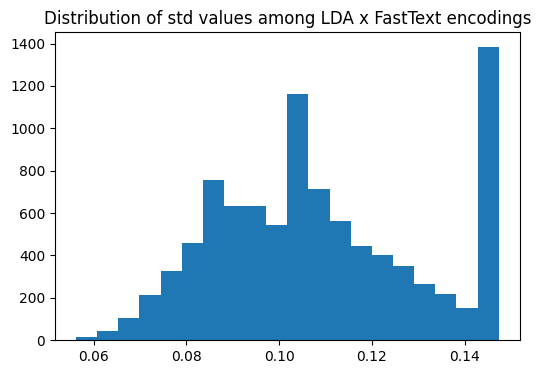

In [55]:
## 濾過前のエンコーディングのstd の分布を確認

import numpy as np
from matplotlib import pyplot as plt

plt.figure(figsize = (6,4))
plt.hist([ np.std(x) for x in main_df['enc'] ], bins = 20)
plt.title(f"Distribution of std values among {encoding_method} encodings")
plt.show()

In [56]:
## 一様分布の事例を除外
import numpy as np

check = False
doc_enc = main_df['enc']
max_std = max([ np.std(x) for x in doc_enc])
if check:
    print(f"std max: {max_std}")

min_std = min([ np.std(x) for x in doc_enc])
if check:
    print(f"std min: {min_std}")

first_min_std = list(sorted(set([ np.std(x) for x in doc_enc])))[-0]
print(f"std 1st min: {first_min_std}")

second_min_std = list(sorted(set([ np.std(x) for x in doc_enc])))[-1]
print(f"std 2nd min: {second_min_std}")

std 1st min: 0.05614772701437825
std 2nd min: 0.1473835357815684


In [57]:
## df_filtered の定義
import numpy as np

print(f"{len(main_df)} instances before filtering")

## 閾値は2番目に小さい値より小さく最小値よりは大きな値であるべき
std_threshold = second_min_std / 6 # 穏健な値を得るために 6で割った
print(f"std_threshold: {std_threshold}")

## Rっぽい次のコードは通らない
#df_filtered = df[ df['encoding'] > std_threshold ]
## 通るのは次のコード: Creating a list of True/False and apply it to DataFrame 
std_tested = [ False if np.std(x) < std_threshold else True for x in main_df['enc'] ]
df_filtered = main_df[ std_tested ]
print(f"Filtering leaves {len(df_filtered)} instances: ({len(main_df) - len(df_filtered)} instances removed)")

9387 instances before filtering
std_threshold: 0.0245639226302614
Filtering leaves 9387 instances: (0 instances removed)


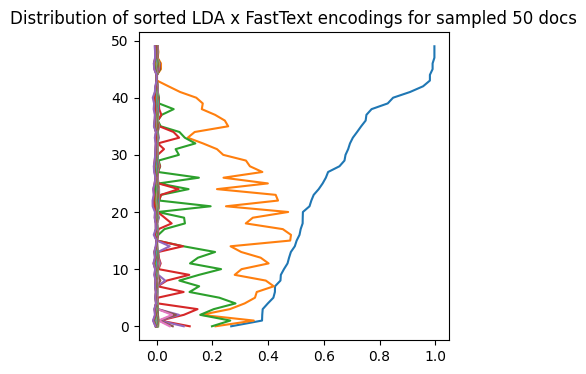

In [58]:
## doc エンコード値の分布を確認

sample_n = 50
E = sorted([ sorted(x, reverse = True) for x in df_filtered['enc'].sample(sample_n) ])
plt.figure(figsize = (4,4))
plt.plot(E, range(len(E)))
plt.title(f"Distribution of sorted {encoding_method} encodings for sampled {sample_n} docs")
plt.show()

In [59]:
df_filtered['language'].value_counts(sort = True).sort_index()

language
arabic        723
dutch        1079
english       828
esperanto     728
french       1000
german        789
icelandic     936
japanese      784
korean        721
spanish       928
swahili       871
Name: count, dtype: int64

Dim Reduct 用の事例サンプリング

In [60]:
## Dim Reduct 用の事例サンプリング = doc_fit_df の定義
if doc_fit_sampling:
    doc_fit_df_original = df_filtered.copy()
    sample_n = round(len(doc_fit_df_original) * doc_fit_sampling_rate)
    doc_fit_df = doc_fit_df_original.sample(sample_n)
    print(f"doc_fit_df has {len(doc_fit_df)} rows after sampling")
else:
    doc_fit_df = df_filtered

doc_fit_df has 1877 rows after sampling


In [61]:
doc_fit_df.columns

Index(['form', 'freq', 'spell', 'sound', 'arabic', 'dutch', 'english',
       'esperanto', 'french', 'german', 'icelandic', 'japanese', 'korean',
       'spanish', 'swahili', 'language', 'family', 'size', '1gram', '2gram',
       '3gram', '4gram', 'skippy2gram', 'skippy3gram', 'skippy4gram', 'enc'],
      dtype='object')

In [62]:
doc_fit_df['language'].value_counts(sort = True).sort_index()

language
arabic       157
dutch        202
english      181
esperanto    126
french       186
german       164
icelandic    178
japanese     148
korean       148
spanish      196
swahili      191
Name: count, dtype: int64

In [63]:
doc_fit_df['family'].value_counts(sort = True).sort_index()

family
arabic      157
english     181
germanic    544
japanese    148
korean      148
romance     508
swahili     191
Name: count, dtype: int64

UMAP を使った可視化 (3D)

In [64]:
## 必要に応じて
#!pip install -U ipywidgets

In [65]:
## UMAP を使った documents のグループ化
import numpy as np
import umap.umap_ as umap

## UMAP の生成
UMAP_3d = umap.UMAP(n_components = 3, random_state = 1, n_jobs = 1,
                    metric = umap_metric,
                    n_neighbors = umap_n_neighbors, min_dist = umap_min_dist)

## データに適用
doc_enc = np.array(list(doc_fit_df['enc']))
doc_UMAP_3d = UMAP_3d.fit_transform(doc_enc)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [66]:
%%capture --no-display

## Plotlyを使って UMAP の結果の可視化 (3D)
import plotly.graph_objects as go
import numpy as np

## 色分けの単位を選択
if color_lang_family:
    colored_var = 'family'
else:
    colored_var = 'language'
## umap_df を作成
X = zip(doc_UMAP_3d[:,0], doc_UMAP_3d[:,1], doc_UMAP_3d[:,2],
        doc_fit_df[colored_var], doc_fit_df[doc_type]) # zip(..)が必要
umap_df = pd.DataFrame(X, columns = ['D1', 'D2', 'D3', colored_var, doc_type])
#
fig = go.Figure()
for lang_name in sorted(set(umap_df[colored_var])):
    # set marker size of the target domain
    traced = umap_df[ umap_df['language'] == lang_name ]
    fig.add_trace(
        go.Scatter3d(
            x = traced['D1'], y = traced['D2'], z = traced['D3'],
            name = lang_name.title(),
            mode = 'markers',
            marker = dict(size = 4, opacity = 0.8),
            marker_colorscale = color_palette, # worked??
            showlegend = True
        )
    )

## 3D 散布図にラベルを追加する処理は未実装
df_size = len(umap_df)
## title_header
title_header = f"UMAP 3D (metric: {umap_metric}; {umap_n_neighbors} neighbors; min dist: {umap_min_dist}) of {df_size} encodings via\n"
## title_body
if use_FastText:
    if use_LDA:
        title_body = f"LDA ({n_topics} topics; term:0 {lda_term_type}) x FastText ({ft_n_dims} dims; term: {ft_term_type}; window: {ft_window_size})"
    else:
        title_body = f"FastText ({ft_n_dims} dims; term: {ft_term_type}; window: {ft_window_size})"
else:
    title_body = f"LDA ({n_topics} topics; term: {lda_term_type})"
#
title_val = title_header + title_body
fig.update_layout(title = dict(text = title_val, font_size = 12), autosize = False, width = 700, height = 700)
fig.show()

t-SNE の結果の可視化 (3D)

In [67]:
## tSNE の結果の可視化: Plotly を使った 3D 描画

import numpy as np
from sklearn.manifold import TSNE as tSNE
import plotly.express as pex
import plotly.graph_objects as go
import matplotlib.pyplot as plt

## tSNE のパラメターを設定
max_perplexity_factor = 3
perplexity_max_val = round(len(doc_fit_df)/max_perplexity_factor)
print(f"perplexity_max_val: {perplexity_max_val}")

divider = 5
perplexity_increment = round(perplexity_max_val/divider)
print(f"perplexity_increment: {perplexity_increment}")

## tSNE を段階的に実行
df_size = len(doc_fit_df)
exit_after_step = 3 # 15 is largest enough to complete the all steps
ppl_vals = enumerate(range(5, perplexity_max_val, perplexity_increment))
for step, ppl_val in ppl_vals:
    ## 早期終了の判定
    if step >= exit_after_step:
        continue
    ## tSNE 事例の生成
    tSNE_3d_varied = tSNE(n_components = 3, random_state = 0, perplexity = ppl_val,
                          n_iter = 1000)

    ## データに適用
    doc_enc = np.array(list(doc_fit_df['enc']))
    doc_tSNE_3d_varied = tSNE_3d_varied.fit_transform(doc_enc)

    ## 色分けの単位を選択
    if color_lang_family:
        colored_var = 'family'
    else:
        colored_var = 'language'
    ##
    X = zip(doc_tSNE_3d_varied[:,0], doc_tSNE_3d_varied[:,1], doc_tSNE_3d_varied[:,2],
            doc_fit_df[colored_var]) # zip(..)が必要
    dfx = pd.DataFrame(X, columns = ['D1', 'D2', 'D3', colored_var])
    ## 作図
    fig = go.Figure()
    for lang in np.unique(main_df[colored_var]):
        traced = dfx[dfx[colored_var] == lang]
        fig.add_trace(
            go.Scatter3d(
                x = traced['D1'], y = traced['D2'], z = traced['D3'],
                name = lang.title(), mode = 'markers', marker = dict(size = 3),
                marker_colorscale = color_palette, # worked??
                showlegend = True
            )
        )
    ## 題の指定
    title_header = f"t-SNE 3D map (ppl: {ppl_val}) of {df_size} encodings for <{doc_attr}> via\n"
    if use_FastText:
        if use_LDA:
            title_body = f"LDA ({n_topics} topics; term: {lda_term_type}) x FastText ({ft_n_dims} dims; term: {ft_term_type}; window: {ft_window_size})"
        else:
            title_body = f"FastText ({ft_n_dims} dims; term: {ft_term_type}; window: {ft_window_size})"
    else:
        title_body = f"LDA ({n_topics} topics; term: {lda_term_type})"
    title_val = title_header + title_body
    fig.update_layout(title = dict(text = title_val, font_size = 13),
                      autosize = False, width = 600, height = 600)
    fig.show()

perplexity_max_val: 626
perplexity_increment: 125


In [68]:
## 必要に応じて adjustText を道入
#!pip install -U adjustText

t-SNE の結果の可視化 (2D)

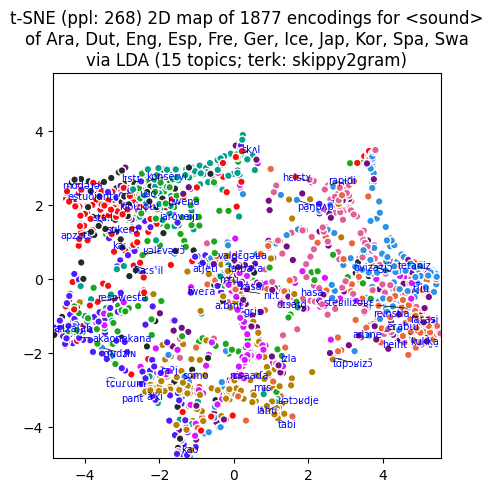

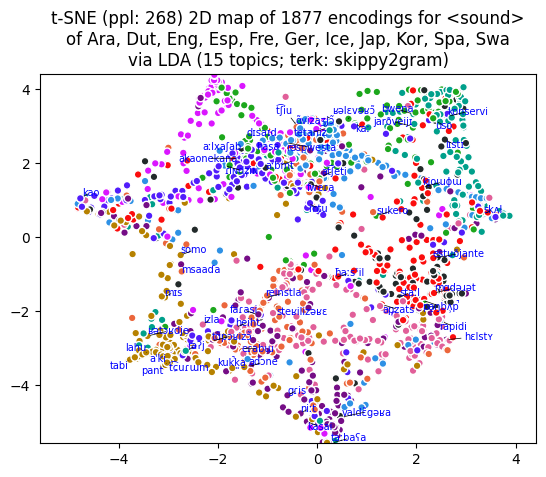

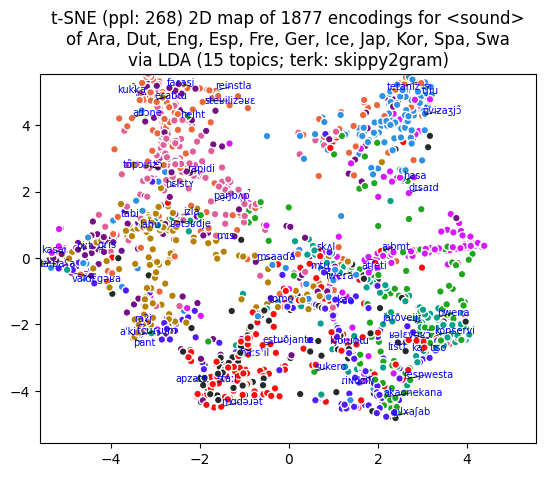

In [69]:
## tSNE の結果の可視化 (2D)

import numpy as np
from sklearn.manifold import TSNE as tSNE
import plotly
import plotly.express as pex
import matplotlib.pyplot as plt
from adjustText import adjust_text

## 次の設定は arabic が文字化けする
#plt.rcParams["font.family"] = "Hiragino Sans" # Windows は別のフォント名を指定する必要がある

## tSNE 事例の生成
ppl_divider = 7
perplexity_selected = round(len(doc_fit_df)/ppl_divider)
doc_perplexity_val = perplexity_selected
doc_tSNE_3d = tSNE(n_components = 3, random_state = 0, perplexity = perplexity_selected, n_iter = 1000)

## 色分けの単位を選択
if color_lang_family:
    colored_var = 'family' # 一部の言語を celtic, germanic, romance, slavic 属に統合
else:
    colored_var = 'language' # 言語名そのまま

## データに適用
doc_enc = np.array(list(doc_fit_df['enc']))
doc_tSNE_3d = doc_tSNE_3d.fit_transform(doc_enc)

## plot_df の定義
X = zip(doc_tSNE_3d[:,0], doc_tSNE_3d[:,1], doc_tSNE_3d[:,2], doc_fit_df[colored_var]) # zip(..)が必要
plot_df = pd.DataFrame(X, columns = ['D1', 'D2', 'D3', colored_var])

## 描画
plt.figure(figsize = (5, 5))
## 配色
plt.set_colors = pex.colors.qualitative.Plotly
## labeling
lab_sampling_rate = 0.03
lab_sample_n = round(len(doc_fit_df) * lab_sampling_rate)
sampled_keys = [ doc[:max_doc_size] for doc in random.sample(list(doc_fit_df[doc_type]), lab_sample_n) ]    
##
check = False
early_exit = False
for step, roll in enumerate([ np.roll([0,1,2], -i) for i in range(0,3) ]):
    ## 早期停止の判定
    if early_exit:
        if step > 0:
            continue
    ## 通常処理
    if check:
        print(roll)
    X, Y = plot_df.iloc[:, roll[0]], plot_df.iloc[:, roll[1]]
    gmax = max(X.max(), Y.max())
    gmin = min(X.min(), Y.min())
    plt.xlim(gmin, gmax)
    plt.ylim(gmin, gmax)

    ## 配色
    colormap = color_palette # == pex.colors.qualitative.Light24
    lang_list = list(set(doc_fit_df[colored_var]))
    cmapped = [ colormap[lang_list.index(lang)] for lang in plot_df[colored_var] ]
    
    ## 作図
    scatter = plt.scatter(X, Y, s = 30, c = cmapped, edgecolors = 'w')

    ## 文字を表示する事例のサンプリング
    texts = [ ]
    ## labels の生成
    for x, y, s in zip(X, Y, sampled_keys):
        texts.append(plt.text(x, y, s, size = 7, color = 'blue'))
        ## label に repel を追加: adjustText package の導入が必要
    adjust_text(texts,
        #force_points = 0.2,
        ## Comment out the following line if you get AttributionError
        force_text = (.1, .2), expand_points = (1, 1), expand_text = (1, 1),
        arrowprops = dict(arrowstyle = "-", color = 'black', lw = 0.5))
    #
    title_header = f"t-SNE (ppl: {perplexity_selected}) 2D map of {len(doc_fit_df)} encodings for <{doc_attr}>\n"
    title_body = f"of {', '.join([ l.title() for l in sorted([ l[:3] for l in selected_langs])])}\n"
    title_tail = f"via LDA ({n_topics} topics; terk: {lda_term_type})"          
    plt.title(title_header + title_body + title_tail)
    #plt.legend(df['language'])
    plt.show()

DBSCAN を使ったクラスタリング

In [70]:
## DBSCAN を使ったクラスタリング

from sklearn.cluster import DBSCAN

DBSCAN_uses_UMAP = True
if DBSCAN_uses_UMAP:
    dbscan_source = doc_UMAP_3d
else:
    dbscan_source = doc_tSNE_3d

## eps は事例ごとに調節が必要
min_samples_val = 2
## looking for optimal eps val compatible with color palette
max_n_clusters = 24 # This depends on the differetiation in color palette used
dbscan_clustered = None
cluster_ids = None
print(f"Looking for the optimal eps val...")
max_val = 5 # needs to be effectively large
eps_vals = np.arange(max_val, 0.005, -0.05)
check = False
for eps_val in eps_vals:
    if check:
        print(f"testing eps = {eps_val:0.4f}")
    dbscan_clustered_local = DBSCAN(eps = eps_val, min_samples = min_samples_val).fit(dbscan_source)
    cluster_ids_local = dbscan_clustered_local.labels_
    if check:
        print(f"result: {np.unique(cluster_ids_local)}")
    try:
        assert len(np.unique(cluster_ids_local)) <= max_n_clusters
        dbscan_clustered = dbscan_clustered_local
        cluster_ids = cluster_ids_local
    except AssertionError:
        break
#
print(f"final result: {np.unique(cluster_ids)}")

Looking for the optimal eps val...
final result: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]


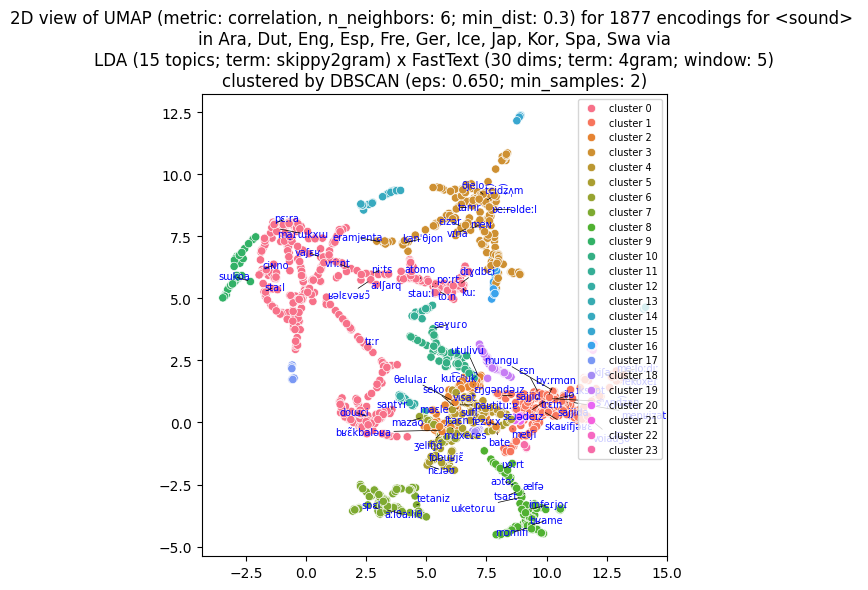

In [71]:
%%capture --no-display

import seaborn as sns
import matplotlib.pyplot as plt

## 日本語表示のための設定
#plt.rcParams["font.family"] = "Hiragino sans" # Windows/Linux の場合は別のフォントを指定

## 凡例の文字の大きさを指定
param_vals = {'legend.fontsize': 7, 'legend.handlelength': 2}
plt.rcParams.update(param_vals)

## 描画
fig = plt.figure(figsize = (6, 6))
#
d1, d2 = dbscan_source[:,0], dbscan_source[:,1]
sns.scatterplot(x = d1, y = d2, hue = [ f"cluster {l}" for l in dbscan_clustered.labels_ ]) # requires Searborn

## 文字を表示する事例のサンプリング
relative = True
if relative:
    lab_sampling_rate = 0.04 # サンプリング率の指定
    lab_sample_n = round(lab_sampling_rate * len(plot_df))
else:
    lab_sample_n = 30 # 絶対数の指定

## 事例名の生成
texts = [ ]
sampled_keys = [ x[:max_doc_size] for x in random.sample(list(doc_fit_df[doc_type]), lab_sample_n) ]
for x, y, s in zip(d1, d2, sampled_keys):
    texts.append(plt.text(x, y, s, size = 7, color = 'blue'))

## label に repel を追加: adjustText package の導入が必要
adjust_text(texts,
        #force_points = 0.2,
        ## Comment out the following line if you get AttributionError
        force_text = (.1, .2), expand_points = (1, 1), expand_text = (1, 1),
        arrowprops = dict(arrowstyle = "-", color = 'black', lw = 0.5))
    
## 題名を指定
## used_domains
used_lang_list = f"{', '.join([ l.title() for l in [ l[:3] for l in selected_langs] ])}"
## title_header
df_size = len(plot_df)
if DBSCAN_uses_UMAP:
    title_header = f"2D view of UMAP (metric: {umap_metric}, n_neighbors: {umap_n_neighbors}; min_dist: {umap_min_dist}) for {df_size} encodings for <{doc_attr}> \nin {used_lang_list} via\n"
else:
    title_header = f"2D view of t-SNE (ppl: {doc_perplexity_val}) for {df_size} encodings for <{doc_attr}> in\n{used_lang_list} via\n"
## title_val
if use_FastText:
    if use_LDA:
        title_body = f"LDA ({n_topics} topics; term: {lda_term_type}) x FastText ({ft_n_dims} dims; term: {ft_term_type}; window: {ft_window_size})"
    else:
        title_boday = f"FastText ({ft_n_dims} dims; term: {ft_term_type}; window: {ft_window_size})"
else:
    title_val = f"LDA ({n_topics} topics; term: {lda_term_type})"
## clustering_method
clustering_method = f"\nclustered by DBSCAN (eps: {eps_val:0.3f}; min_samples: {min_samples_val})"
#
title_val = title_header + title_body + clustering_method
plt.title(title_val)
plt.show()
## 局在の程度は character 1-gram, (skippy) 2-gram, (skippy) 3-gram のどれを使うかで違って来る．

In [72]:
## co-clusteredness に基づく言語間類似度の計算

import pandas as pd
from sklearn.cluster import DBSCAN

#DBSCAN_uses_UMAP = True # tSNE は有効でないようだ
if DBSCAN_uses_UMAP:
    dbscan_source = doc_UMAP_3d
else:
    dbscan_source = doc_tSNE_3d

## eps, min_samples は事例ごとに調節が必要
min_samples_val = 2

## 精度を上げるために，クラスター数を多目にする
scaling_factor = 5
max_n_clusters_for_correl = round(len(selected_langs) * scaling_factor)
print(f"max_n_clusters_for_correl")

print(f"Looking for the optimal value for eps...")
check = False
x_dbscan_clustered = None
x_cluster_ids = None
max_val = 5 # needs to be effectively large
eps_vals = np.arange(max_val, 0.005, -0.05)
for eps_val in eps_vals:
    if check:
        print(f"testing eps = {eps_val:0.4f}")
    x_dbscan_clustered_local = DBSCAN(eps = eps_val, min_samples = min_samples_val).fit(dbscan_source)
    x_cluster_ids_local = x_dbscan_clustered_local.labels_
    if check:
        print(f"result: {np.unique(x_cluster_ids_local)}")
    try:
        assert len(np.unique(x_cluster_ids_local)) <= max_n_clusters_for_correl
        x_dbscan_clustered = x_dbscan_clustered_local
        x_cluster_ids = x_cluster_ids_local
    except AssertionError:
        break
#
print(f"final result: {np.unique(x_cluster_ids)}")

## clusterごとに言語の帰属数を集計
selector_var = 'language'
bindings = zip(doc_fit_df[doc_type], doc_fit_df[selector_var], x_dbscan_clustered.labels_)
binding_df = pd.DataFrame(bindings, columns = ['form', selector_var, 'cluster'])

selector_names = sorted(set(binding_df[selector_var]))
print(f"selector_names: {selector_names}")

cluster_ids = sorted(set(binding_df['cluster']))
print(f"cluster ids: {cluster_ids}")

clusterwise_counts = { selector_name : None for selector_name in selector_names }
for selector_name in selector_names:
    counts = [ ]
    selected = binding_df[ binding_df[selector_var] == selector_name ]
    for i, cluster_id in enumerate(cluster_ids):
        matched = selected[ selected['cluster'] == cluster_id ]
        n_matches = len(matched)
        if n_matches == 0:
            counts.append(0)
        else:
            counts.append(int(n_matches))
    clusterwise_counts[selector_name] = counts

## クラスターでの生起個数の間の相関を計算
clusterwise_counts_df = pd.DataFrame.from_dict(clusterwise_counts) ## Truly versatile
clusterwise_counts_df

max_n_clusters_for_correl
Looking for the optimal value for eps...
final result: [-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22
 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46]
selector_names: ['arabic', 'dutch', 'english', 'esperanto', 'french', 'german', 'icelandic', 'japanese', 'korean', 'spanish', 'swahili']
cluster ids: [-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46]


,arabic,dutch,english,esperanto,french,german,icelandic,japanese,korean,spanish,swahili
0,0,0,1,1,0,0,1,0,1,1,0
1,11,0,0,5,3,1,4,11,38,8,71
2,0,15,1,0,0,2,0,0,0,0,0
3,0,57,32,0,3,15,2,0,2,0,0
4,0,9,1,0,0,6,0,0,0,0,0
5,0,0,0,2,1,1,0,13,6,3,2
6,0,0,0,12,0,1,0,2,1,19,1
7,0,0,2,7,0,0,0,42,30,11,13
8,0,0,1,1,0,0,0,0,7,2,4
9,2,8,45,0,5,17,14,1,0,0,5


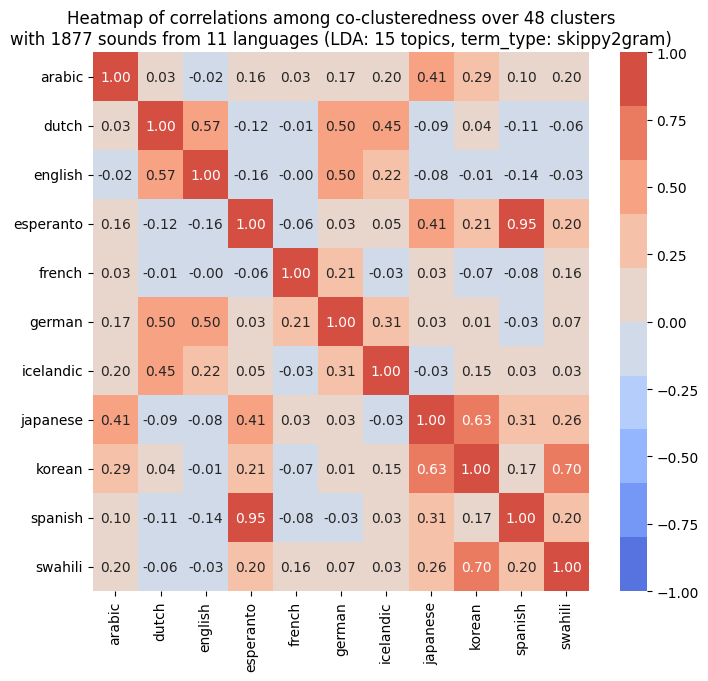

In [73]:
## Heatmap で可視化

import seaborn as sns

counts_df_normalized = (clusterwise_counts_df - clusterwise_counts_df.min())/(clusterwise_counts_df.max() - clusterwise_counts_df.min())
corr_df = counts_df_normalized.corr()
#corr_df.sort_index(axis = 0, inplace = True)
#corr_df.sort_index(axis = 1, inplace = True)

n_selectors = len(selector_names)
fig = plt.figure(figsize = (round(n_selectors * 0.7), round(n_selectors * 0.6)))
sns.heatmap(corr_df, cmap = sns.color_palette('coolwarm', 10),
            annot = True, fmt = '.2f', vmin = -1, vmax = 1)

title_val = f"Heatmap of correlations among co-clusteredness over {len(cluster_ids)} clusters\nwith {len(dbscan_source)} {doc_attr}s from {n_selectors} {selector_var}s (LDA: {n_topics} topics, term_type: {lda_term_type})"
plt.title(title_val)
plt.show()

階層クラスタリングのための部分サンプリングの追加

In [74]:
## 階層クラスタリングのための事例のサンプリング

df_size = len(doc_fit_df)
hc_sampling_rate = 0.1 # 大きくし過ぎると図が見にくい
hc_sample_n = round(df_size * hc_sampling_rate)
doc_hc_df = doc_fit_df.sample(hc_sample_n)
##
print(f"{hc_sample_n} rows are sampled")
doc_hc_df[colored_var].value_counts(sort = True).sort_index()

188 rows are sampled


language
arabic       20
dutch        22
english      18
esperanto     9
french       22
german       12
icelandic    13
japanese     15
korean       19
spanish      18
swahili      20
Name: count, dtype: int64

階層クラスタリングの実行

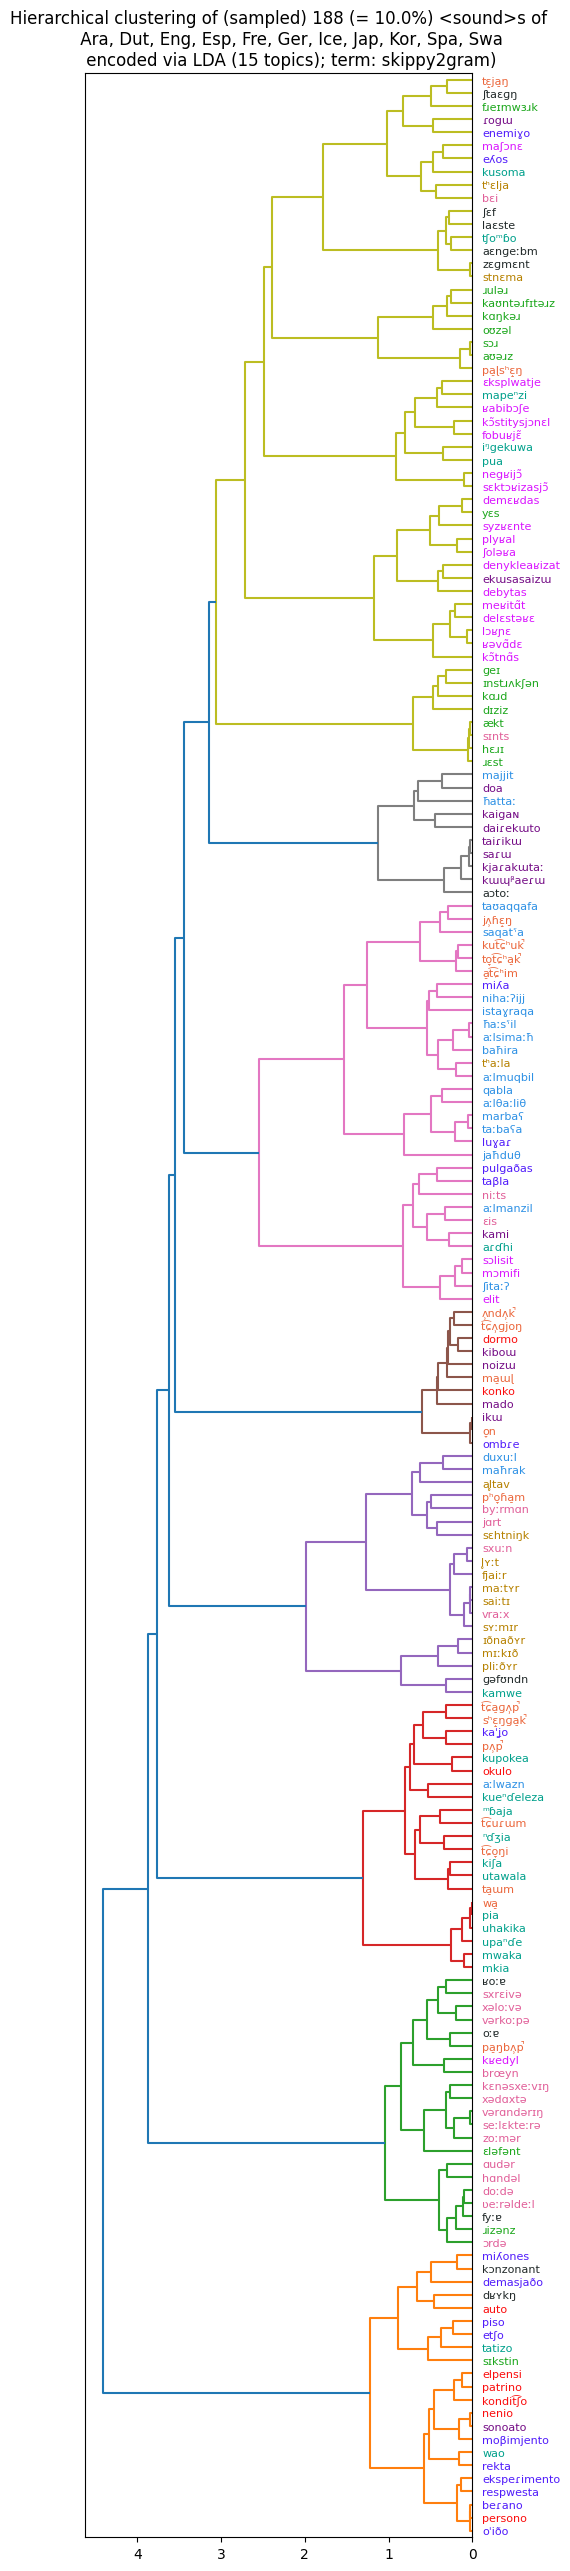

In [75]:
## doc 階層クラスタリングの実行

import numpy as np
import plotly
import matplotlib.pyplot as plt
## 次の設定は arabic, bengali が文字化けする
#plt.rcParams["font.family"] = "Hiragino Sans" # Windows は別のフォント名を指定する必要がある

## 描画サイズの指定
plt.figure(figsize = (5, round(len(doc_hc_df) * 0.17))) # This needs to be run here, before dendrogram construction.

## 事例ラベルの生成
label_vals = [ x[:max_doc_size] for x in list(doc_hc_df[doc_type]) ] # truncate doc keys

## 樹状分岐図の作成
from scipy.cluster.hierarchy import dendrogram, linkage

## 距離行列の生成
doc_hc_enc = list(doc_hc_df['enc'])
doc_linkage = linkage(doc_hc_enc, method = 'ward', metric = 'euclidean')
dendrogram(doc_linkage, orientation = 'left', labels = label_vals, leaf_font_size = 8)

## 描画
plt.title(f"Hierarchical clustering of (sampled) {len(doc_hc_df)} (= {100 * hc_sampling_rate}%) <{doc_attr}>s of\n \
    {', '.join([ l.title()[:3] for l in sorted(selected_langs)])}\n \
    encoded via LDA ({n_topics} topics); term: {lda_term_type})")

## ラベルに language に対応する色を付ける
lang_colors = { lang_name : i for i, lang_name in enumerate(np.unique(doc_hc_df[colored_var])) }
ax = plt.gca()
for ticker in ax.get_ymajorticklabels():
    form = ticker.get_text()
    row = doc_hc_df.loc[doc_hc_df[doc_type] == form]
    lang = row[colored_var].to_string().split()[-1] # trick
    try:
        lang_id = lang_colors[lang]
    except (TypeError, KeyError):
        print(f"color encoding error at: {lang}")
    #
    ticker.set_color(color_palette[lang_id])
#
plt.show()
## A few Turkish words will be partially garbled.